<img src="UIUC_ZJGSU.png" width="30%">

# Publication

### Task-adaptive eigenvector-based projection (EBP) transform for compressed sensing: A case study of spectroscopic profiling sensor [J]. Analytical Science Advances. Chemistry Europe, 2021, doi: 10.1002/ansa.202100018

https://chemistry-europe.onlinelibrary.wiley.com/share/BTM5WTN8W44FYQRFED6Q?target=10.1002/ansa.202100018

# Install 

This code uses our 'cs1' package (https://github.com/zhangys11/cs1)   

`pip install cs1`

You also need to install our 'qsi-tk' package to use the data I/O functions,  

`pip install qsi-tk`

# 1. Load Data

7344_C01.txt - Raman spectroscopic profiling dataset of 8-year Gujing Tribute vintage liquors from five batches. 
The dataset contains 310 samples. Each sample has 2088 Raman wavenumbers, ranging from 251 to 2338 cm-1.  

The file is tab-separated.

load dataset from 7344.txt
X.shape (310, 2088)


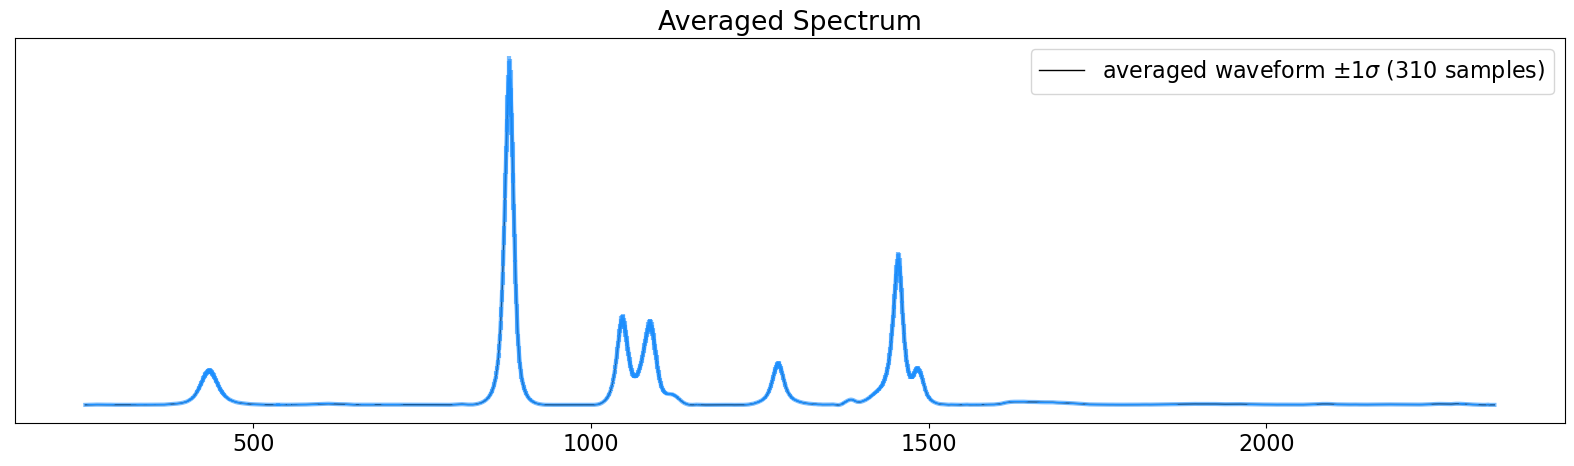

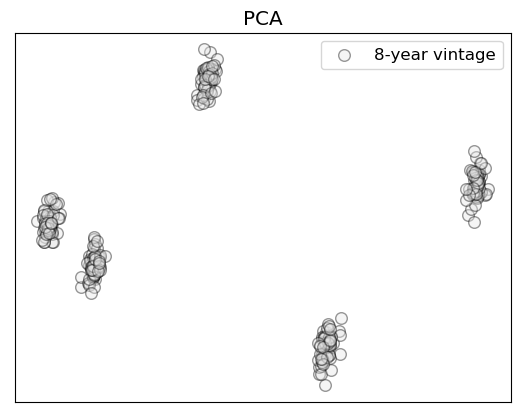

7344.txt - Raman spectroscopic profiling dataset of 8-year Gujing Tribute vintage liquors. 
The dataset contains 310 samples. Each sample has 2088 Raman wavenumbers, ranging from 251 to 2338 cm-1.

--------------------
If you use this data set, please add the reference: 
[1] A unified classifiability analysis framework based on meta-learner and its application in spectroscopic profiling data [J]. Applied Intelligence, 2021, doi: 10.1007/s10489-021-02810-8


In [1]:
from qsi import io

X, _, X_names, _, labels = io.load_dataset('vintage')

# 2. Basis Selection

The basis matrix  $\Psi$  is used to transform and inverse-transform a signal from one space to another. Because CS requires sparsity, while the original signal is usually not, we need to find a transform to get a sparse representation in the latent space.

$\Psi$ is a `unitary matrix`. i.e. its conjugate transpose is also its inverse, or $\Psi^H = \Psi^{-1}$  
For real matrices, unitary is the same as `orthogonal`.

##  Non-adaptive bases

Non-adaptive basis matrices: IDM (Identity matrix, just for theoretical comparison), DCT ( discrete cosine transform), DFT (which is widely used in medical imaging), HWT (Hadamard-Walsh transform, which is widely used in signal processing).  
IDM doesn't transform into other spaces. It is just for theoretical purpose.  

The above bases are "non-adpative" or "general-purposed". This is both their advantage (don't rely specific signal or make domain-special assumption) and disadvantage (cannot fully leverage domain-specific prior knowledge).  


Next, we will use the domain dataset to design a task-adaptive EBP transform basis.   

In [2]:
import numpy as np
X = np.hstack((X, np.zeros( (len(X), 2090 - X.shape[1]) ))) # we extend X to 2090 cols to reuse the pkl
print(X.shape)

# Load PSIs back from pickle
import pickle

m, n = X.shape
file = open('PSIs_' + str(n) + '.pkl','rb')
PSIs = pickle.load(file)
file.close()

(310, 2090)


# 3. EBP (Eigenvector-Based Project) via SVD (Singular Value Decomposition)

SVD is a kind of matrix facterization. SVD decomposes the matrix into 3 matrices.  
By only taking the first k columns of V, we get a n x k matrix.   
Multiply X with Vk, we get a condensed representation in the PCA (Principle Component Analysis) space.    
Vk is the dictionary matrix that can extract only the k most important features/components.  

In the scenario of CS, we will not use V for dimensionarlilty reduciton (as PCA does). Instead, we will use the entire V as the sparsity transform matrix.   
In the following experiment, we will show V from SVD can be used as a valid CS basis matrix.  

### EBP

For the entire data set  
Projection:  $Z = XW_h$   
Reconstruction: $ZW = XW_hW = X$   

For one sample, $x=\Psi z$    
Projection:  $z = W_hx$   
Reconstruction: $Wz = WW_hx = x$    

W is the $\Psi$ for PCA

Each row of W is the loadings for each PC.

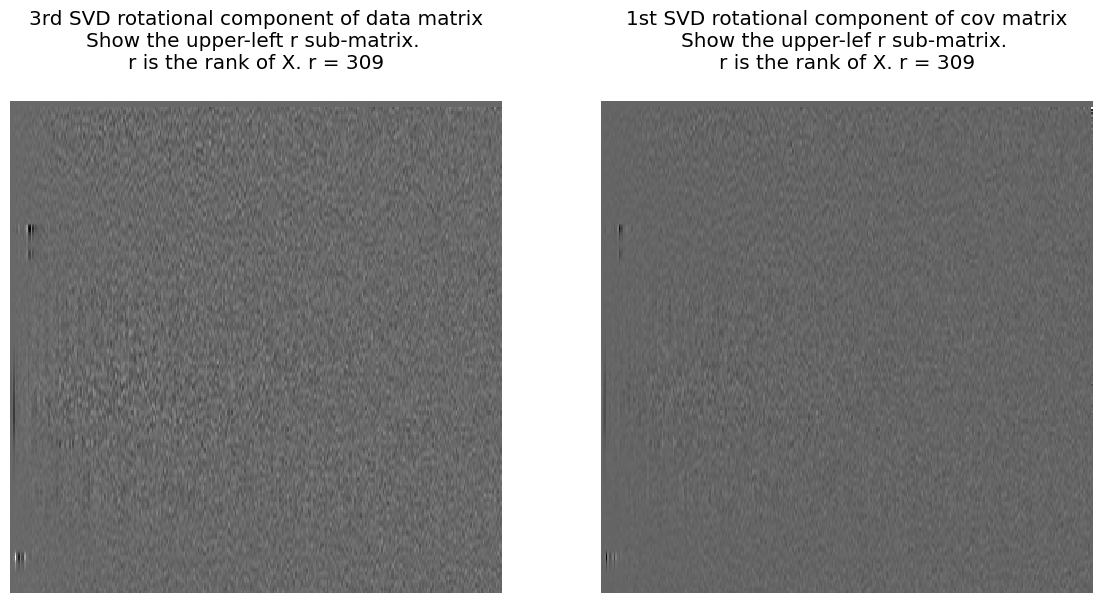

In [3]:
import cs1.basis.adaptive

W,Q2 = cs1.basis.adaptive.EBP(X[1:])

The first orthogonal matrix from SVD of Cov equals the third matrix from SVD of X (W).

### 2.3.1 CS Sampling and Reconstruction with EBP - a quick on the test sample

non-zero coefs:  1


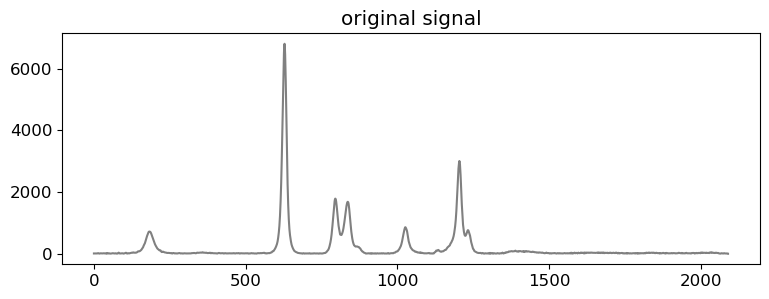

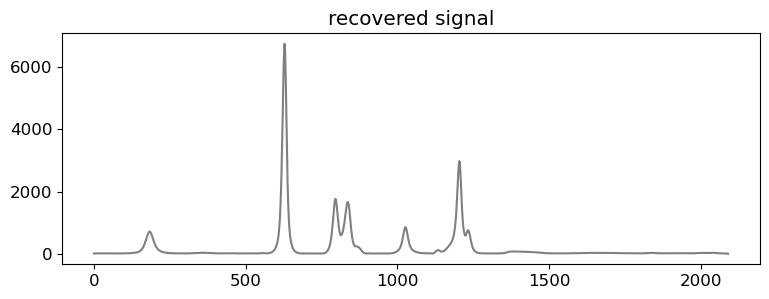

In [4]:
cs1.basis.adaptive.EBP_Sensing_n_Recovery(W, X[0], n_components = 1, k = 0.1)

Some observations: 

1. 甚至可令$\Psi = W[:,:K]$, 使用非方阵，即只复原包含有前K个PC的主体信号。该处理无法提高压缩感知的效率（对信号发送端无影响），仅能提高L1-norm的优化效率（信号接收端）。

2. With k = 0.1, z in the EBP latent space is very sparsee, with only a few non-zero element. The reconstruction quality is good.

3. 无论使用 W（直接对X做SVD）还是 Q2（对CovMatrix做SVD），得到的basis matrix相近，z 及 xr 也类似

# 3. A preliminary analysis on all the $ \Psi $ Candidates (compare their signal reconstruction qualities)


-------------
The following are dynamic properties of each PSI:


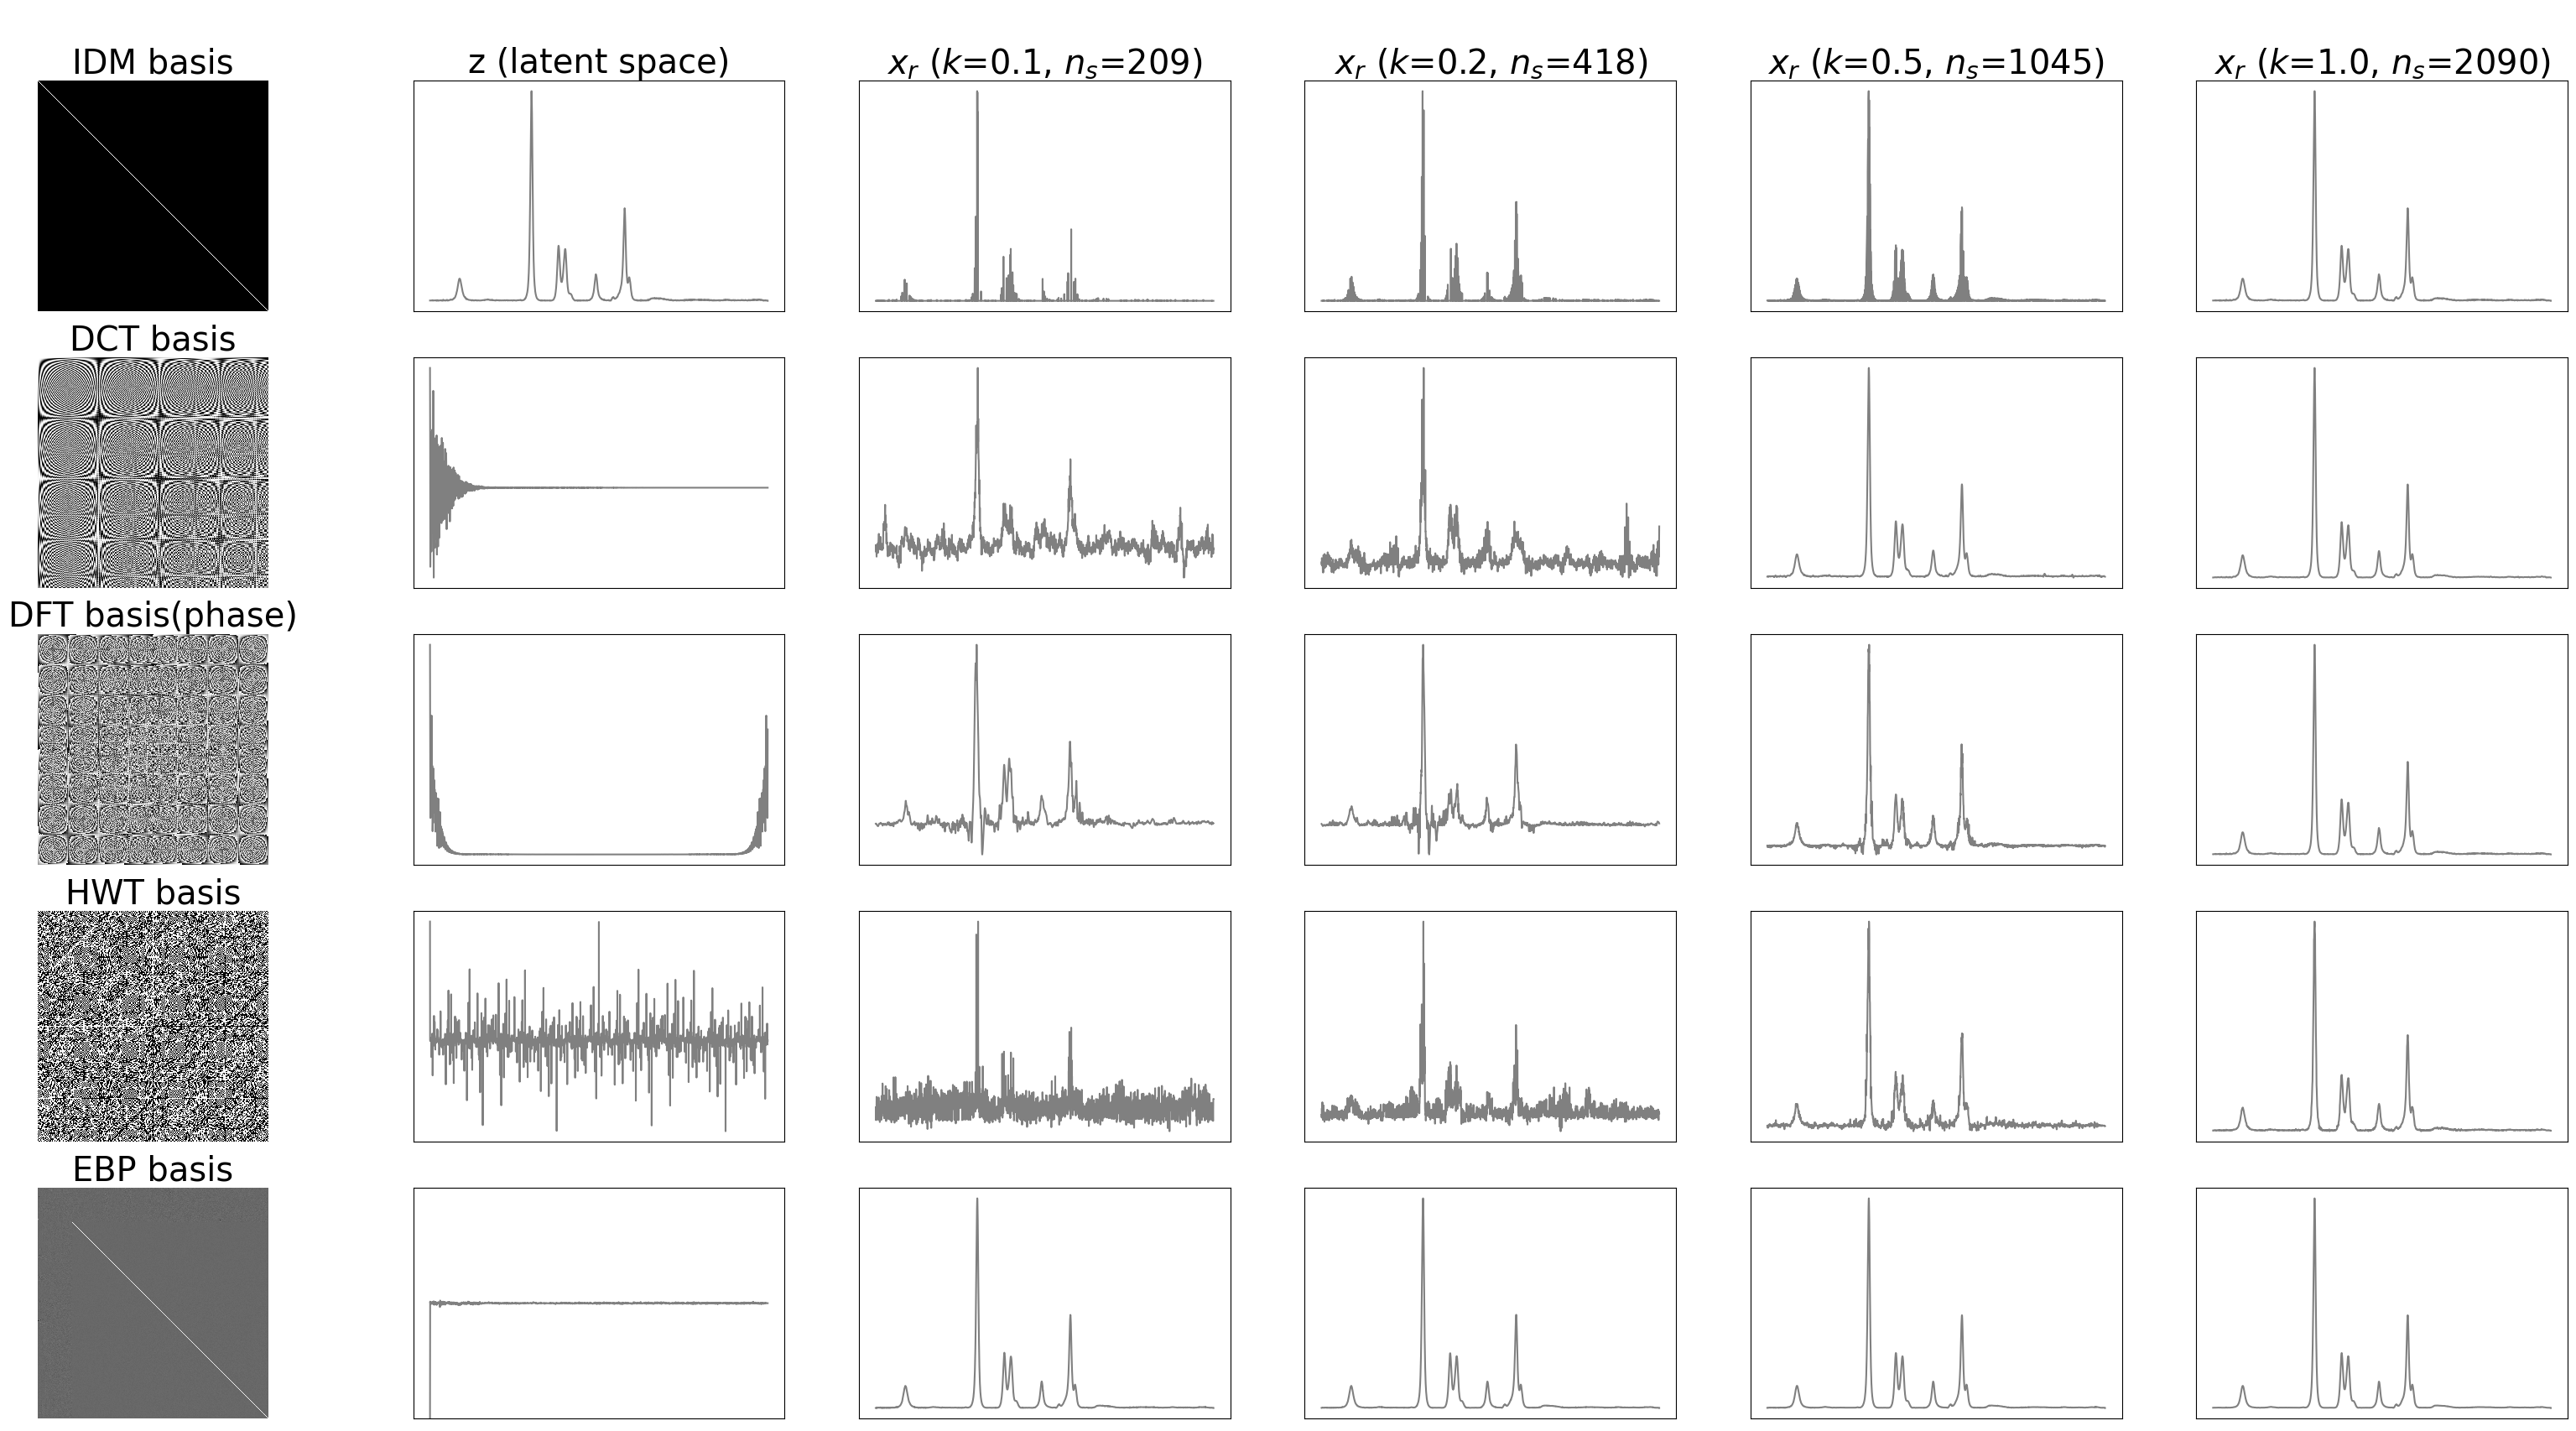

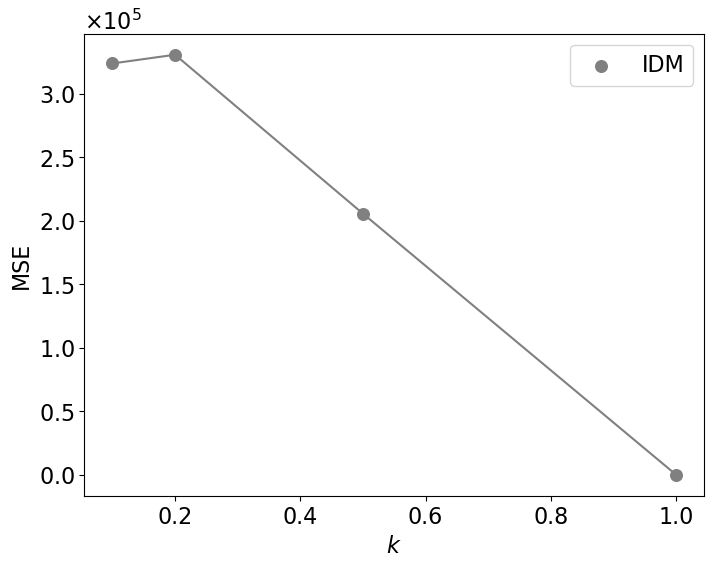

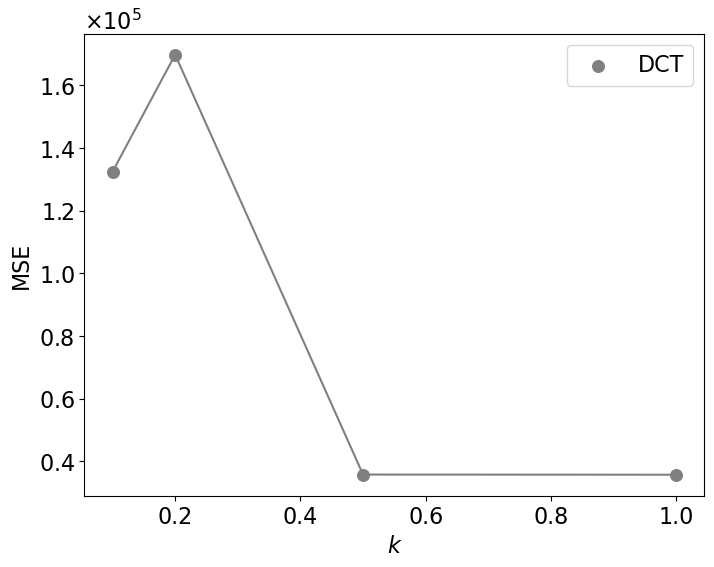

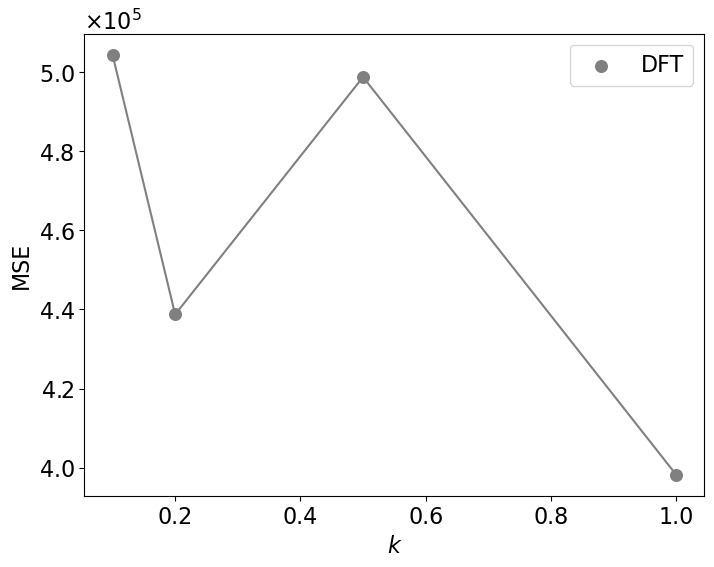

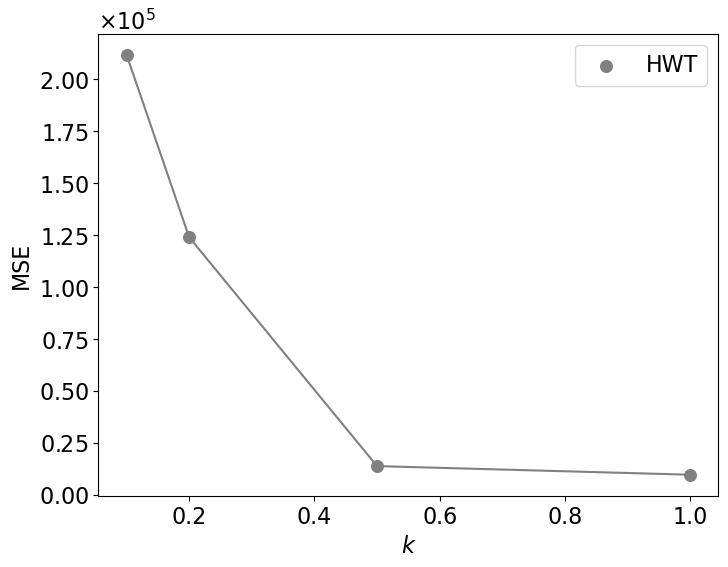

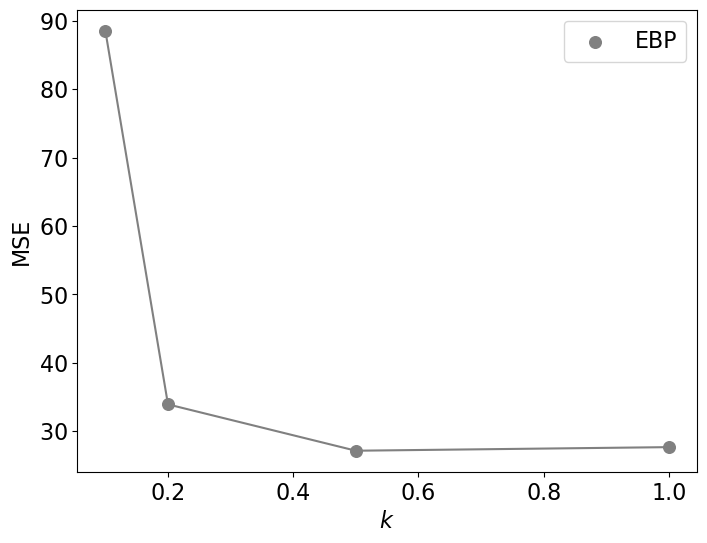

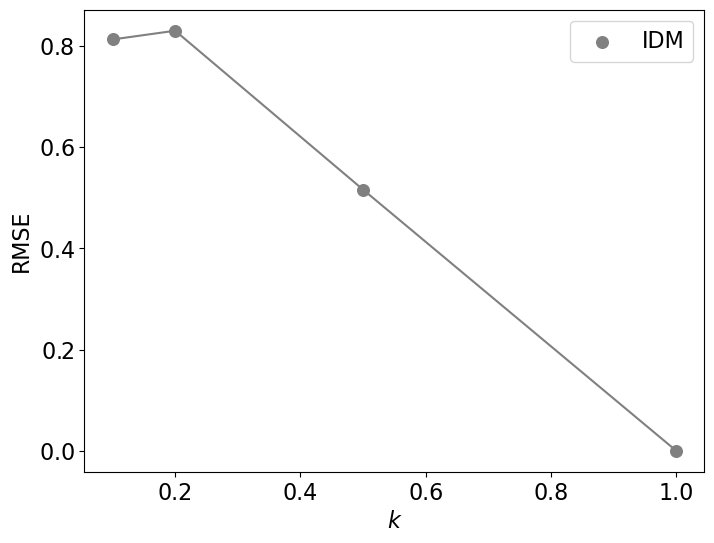

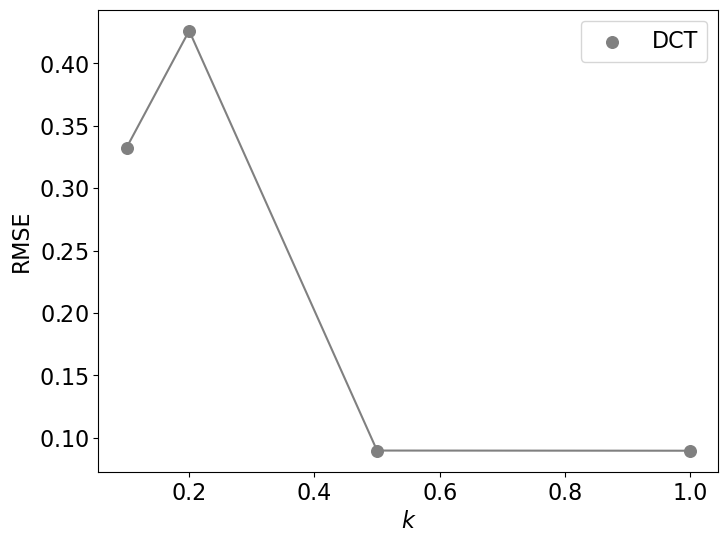

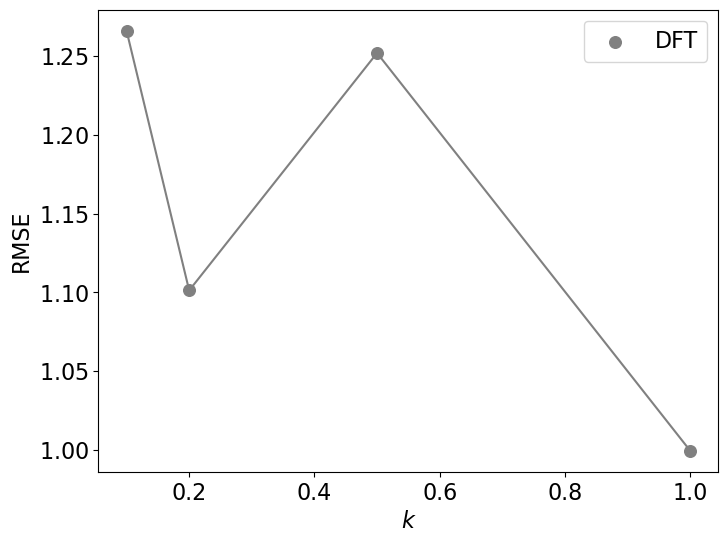

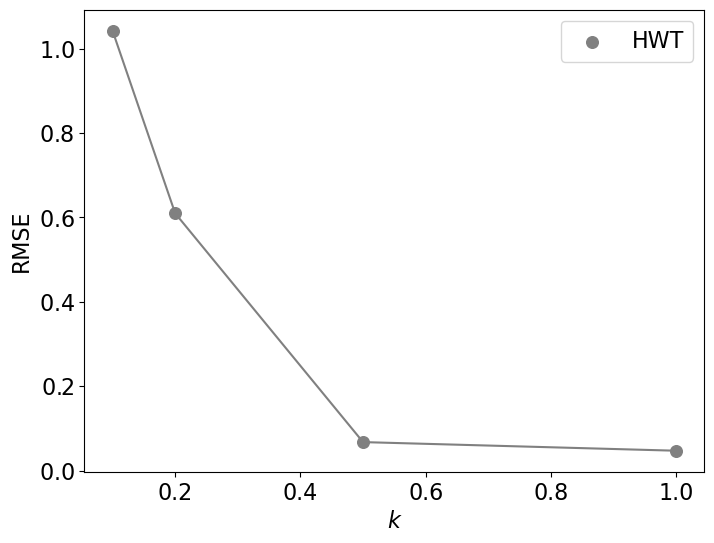

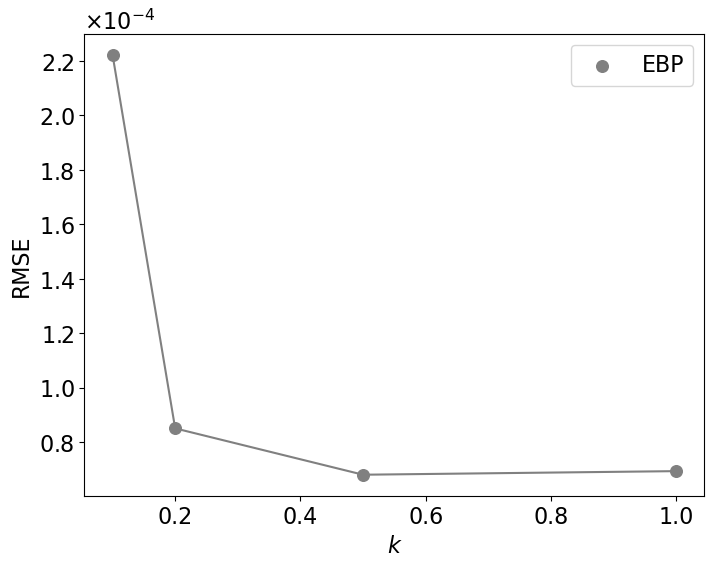

In [5]:
from cs1 import cs

newPSIs = {}
for key in ['IDM', 'DCT', 'DFT', 'HWT']:
    newPSIs[key] = PSIs[key]
newPSIs['EBP'] = W

mses, rmses = cs.GridSearch_Sensing_n_Recovery(X[0], newPSIs, ks = [0.1, 0.2, 0.5, 1.001])

<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><hr/>

The following codes are out-dated. We preserve them for original article publication. 

# 4. Model Evaluation 

## 4.1. LOOCV (Leave-one-out cross validation)

We no longer use LOOCV, should use rdv-CV

    # Leave-one-out validation

    import pylab, matplotlib, sys
    from tqdm import tqdm
    from numpy.linalg import pinv, inv, svd

    psi_names = ['IDM', 'DCT', 'DFT', 'HWT', 'EBP']
    ks = [0.001, 0.01, 0.1, 0.2, 0.5]

    RMSESS = []

    for j in tqdm(range(len(X))):

        x = X[j]    
        XN = np.delete(X, [1], axis=0)

        Q, R, Wh = svd(XN)
        # Wh is already transposed. WH = W.T  
        # W is the PSI for PCA  # W.conj().T == inv(W)
        # Each column is an eigenvector, or PC loadings
        W = Wh.T   

        RMSES = []

        for idx, PSI in enumerate(PSIS):

            psi_name = psi_names[idx]
            if (psi_name == "EBP"):
                PSI = Wh.T
            else:
                PSI = np.array(PSI)

            # padded version
            xe = np.copy(x)

            # pad x with zero if necessary
            if (len(x) < len(PSI)): # the HWT case
                xe = np.zeros(len(PSI))
                xe[:len(x)] = x
            if len(xe) % 2 == 1:
                xe = xe[:-1] # xe = np.append(xe, 0) # make even length, as required by some transform, e.g., DCT
                PSI = PSI[:-1,:-1] # align with xe


            PSI_H = PSI.conj().T
            PSI_INV = np.linalg.pinv(PSI)    
            assert np.allclose(PSI_H, PSI_INV)

            #print(PSI_H)
            #print(PSI_INV)
            # theoretically, PSI_H == PSI_INV
            z = (PSI_H @ xe).ravel().tolist()
            # print((xx @ PSI_H).shape)
            # print("z =", z[:10])
            MAX = np.max(np.abs(z)) # abs(max(z, key=abs))
            # print(MAX)
            thresholds = np.array(range(100)) / 50000

            rs =[]
            for threshold in thresholds:
                rs.append((np.abs(np.array(z)) <= threshold * MAX).sum() / len(z))

            auc = 0
            for i in range(1000):
                auc += (np.abs(np.array(z)) <= (i+1)/1000 * MAX).sum() / len(z)        
            auc = auc/1000

            r = (np.abs(np.array(z)) <= 0.001 * MAX).sum() / len(z)  #   # use 0.001 MAX ABS as threshold # sys.float_info.epsilon


            rmses = []

            for kidx, k in enumerate(ks):

                ########## sensing #############

                PHI, OMEGA = getSensingMatrix(len(xe), k)
                xs = PHI @ xe

                ####### reconstruction ##########

                pidx = np.argmax(PHI, axis = 1)
                A = csmtx(len(xe), pidx, psi_name)
                W = None
                if (psi_name == 'HWT' or psi_name == 'EBP'):
                    W = PSI
                    A = PHI @ W
                xr, zr = lasso_cs(A, xs, 0.0005, psi_name, silent = True, W = W)

                _, _, rmse = calculate_recon_error(xe.reshape(-1,1), xr.reshape(-1,1)) #(np.matrix(xe), np.matrix(xr))        
                rmses.append(rmse)

            RMSES.append(rmses)

        RMSESS.append(RMSES)

## 4.2. Repeated double k-fold cross validation (rdk-CV) 

The arguably best strategy is ten-fold cross validation. [A study of cross-validation and bootstrap for accuracy estimation and model selection].  

The stratified K-fold cross-validation is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class. Because we don’t have a target variable y in this research, stratified CV equals a normal CV.

Because we have a hyper-parameter $ \alpha $ (the regulization coefficient) in the LASSO-based reconstruction function to optimize, we use rdk-CV and optimize the hyper-parameter in the inner CV loop.  

    Total splits (outer loop) from RepeatedStratifiedKFold:  20
    test set RMSE = 1.0003616124975372, L1 =  10  PSI = IDM, k = 0.001
    test set RMSE = 0.9979836613188667, L1 =  10  PSI = IDM, k = 0.01
    test set RMSE = 0.9189193340268842, L1 =  0.1  PSI = IDM, k = 0.1
    test set RMSE = 0.8494146193079973, L1 =  0.1  PSI = IDM, k = 0.2
    test set RMSE = 0.5723394405633982, L1 =  0.1  PSI = IDM, k = 0.5
    LASSO CALLs:  1275
    test set RMSE = 1.0, L1 =  10  PSI = DCT, k = 0.001
    test set RMSE = 0.9948795248514309, L1 =  0.001  PSI = DCT, k = 0.01
    ...
    
Caution: It takes nearly 7 hours to finish rdk-CV.

### RDCV takes long time to run. We can save the result to pkl file and load back later.

### Load back RMSE and TIME result

### 4.2.1. Visualize Reconstruction Time

### 4.2.2. Summarize RMSE and SNR

In [6]:
# -> dB
np.round(np.log10([4769.685, 22771.052, 46235.079, 145835.789])*10)

array([37., 44., 47., 52.])